<a href="https://www.kaggle.com/code/bernardrr/global-food-price-analysis?scriptVersionId=124584426" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Global Food Price Analysis

## Installing Dependencies

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 2.4 MB/s eta 0:00:00


## Importing Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import requests
import yfinance as yf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/usd-equivalent/usd_equivalent.csv
/kaggle/input/global-food-prices/wfp_market_food_prices.csv
/kaggle/input/oak-intelligence-data/food_prices_large.csv


In [3]:
df = pd.read_csv("/kaggle/input/global-food-prices/wfp_market_food_prices.csv", encoding="ISO-8859-1")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743914 entries, 0 to 743913
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   adm0_id             743914 non-null  int64  
 1   adm0_name           743914 non-null  object 
 2   adm1_id             743914 non-null  int64  
 3   adm1_name           729965 non-null  object 
 4   mkt_id              743914 non-null  int64  
 5   mkt_name            743914 non-null  object 
 6   cm_id               743914 non-null  int64  
 7   cm_name             743914 non-null  object 
 8   cur_id              743914 non-null  int64  
 9   cur_name            743914 non-null  object 
 10  pt_id               743914 non-null  int64  
 11  pt_name             743914 non-null  object 
 12  um_id               743914 non-null  int64  
 13  um_name             743914 non-null  object 
 14  mp_month            743914 non-null  int64  
 15  mp_year             743914 non-nul

In [5]:
df.head()

,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_id,cur_name,pt_id,pt_name,um_id,um_name,mp_month,mp_year,mp_price,mp_commoditysource
0,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,1,2014,50.0,WFP
1,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,2,2014,50.0,WFP
2,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,3,2014,50.0,WFP
3,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,4,2014,50.0,WFP
4,1,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread,87,AFN,15,Retail,5,KG,5,2014,50.0,WFP


## Data Cleaning

In [6]:
cols_to_drop = [col for col in df.columns if col.endswith('_id')]
df.drop(cols_to_drop, axis=1, inplace=True)

In [7]:
# month_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April',
#              5: 'May', 6: 'June', 7: 'July', 8: 'August',
#              9: 'September', 10: 'October', 11: 'November', 12: 'December'}

# df['mp_month'] = df['mp_month'].map(month_map)

In [8]:
column_map = {'adm0_name': "Country", 'adm1_name': "Region", 'mkt_name': "Market", 'cm_name': "Commodity", 'cur_name':"Currency", 'pt_name': "Market_type",'um_name': "Quantity", 'mp_month': "Month", 'mp_year': "Year", 'mp_price': "Price", 'mp_commoditysource': "Source"}
df = df.rename(columns=column_map)

In [9]:
currency_list = list(df["Currency"].unique())

In [10]:
#Data Keeps changing so in order to have consistent data, I have commented this code out
# missing_currencies = []

# for currency in currency_list:
#     try:
#         ticker = currency + '=X'
#         exchange_rate = yf.Ticker(ticker).info['regularMarketPrice']
#     except:
#         missing_currencies.append(currency)

# print(missing_currencies)

In [11]:
#The aim of converting to USD is to standardize all currency
# Currencies not in Yahoo Finance
missing_currencies = ['Somaliland Shilling', 'NIS', 'SSP']

In [12]:
#New df with all currencies on Yahoo Finance
new_df = df[~df['Currency'].isin(missing_currencies)]

In [13]:
# This code couldn't work properly probably because of the size of the data
# # define a function to convert a price to USD
# def convert_to_usd(price, currency):
#     if currency == 'USD':
#         return price
#     else:
#         ticker = currency + '=X'
#         try:
#             exchange_rate = yf.Ticker(ticker).info['regularMarketPrice']
#             return price * exchange_rate
#         except:
#             print(f"Error converting {currency} to USD. Setting value to 0.")
#             return 0

# # define a function to convert all the prices in a dataframe to USD
# def convert_prices_to_usd(df, batch_size=1000):
#     num_batches = (len(df) + batch_size - 1) // batch_size
#     for i in range(num_batches):
#         start = i * batch_size
#         end = min((i + 1) * batch_size, len(df))
#         batch = df.iloc[start:end]
#         # apply the convert_to_usd function to each row of the batch
#         batch['USD_Price'] = batch.apply(lambda row: convert_to_usd(row['Price'], row['Currency']), axis=1)
#         # update the currency column to USD
#         batch['USD_currency'] = 'USD'
#         # update the dataframe with the processed batch
#         df.iloc[start:end] = batch
#     # return the updated dataframe
#     return df

In [14]:
# New list of currencies i.e on Yahoo Finance
new_list = list(new_df["Currency"].unique())

In [15]:
# # Creating a dataframe of the currencies and their USD equivalent for easier conversion
# results = {}

# # iterate over the currencies and get their USD equivalent
# for currency in new_list:
#     ticker = currency + "=X"
#     try:
#         exchange_rate = yf.Ticker(ticker).info['regularMarketPrice']
#         results[currency] = exchange_rate
#     except:
#         print(f"Error converting {currency} to USD. Setting value to 0.")
#         results[currency] = 0

# # create a new dataframe from the dictionary
# results_df = pd.DataFrame.from_dict(results, orient='index', columns=['USD Equivalent'])

In [16]:
# # Removing the index and making it a column for easy merge with the main dataframe
# results_df = results_df.reset_index().rename(columns={'index': 'Currency'})

In [17]:
# #Saving as csv because the prices keep changing and are in realtime. I saved to avoid inconsistencies.
# results_df.to_csv("usd_equivalent.csv", index=False)

In [18]:
results_df = pd.read_csv("/kaggle/input/usd-equivalent/usd_equivalent.csv")

In [19]:
# Merging the two dataframes to perform conversion
merged_df = pd.merge(new_df, results_df, on='Currency')

In [20]:
merged_df

,Country,Region,Market,Commodity,Currency,Market_type,Quantity,Month,Year,Price,Source,USD Equivalent
0,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,1,2014,50.0,WFP,86.6779
1,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,2,2014,50.0,WFP,86.6779
2,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,3,2014,50.0,WFP,86.6779
3,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,4,2014,50.0,WFP,86.6779
4,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,5,2014,50.0,WFP,86.6779
...,...,...,...,...,...,...,...,...,...,...,...,...
732406,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,1,2017,119.0,CAPMAS,30.9499
732407,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,2,2017,122.0,CAPMAS,30.9499
732408,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,3,2017,127.0,CAPMAS,30.9499
732409,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,4,2017,132.0,CAPMAS,30.9499


In [21]:
# Converting all prices to USD
merged_df["Price_USD"] = merged_df["Price"] / merged_df["USD Equivalent"]

In [22]:
# Making the Price_USD column a 2dp float
merged_df["Price_USD"] = merged_df["Price_USD"].apply(lambda x: f'{x:.2f}')

In [23]:
merged_df

,Country,Region,Market,Commodity,Currency,Market_type,Quantity,Month,Year,Price,Source,USD Equivalent,Price_USD
0,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,1,2014,50.0,WFP,86.6779,0.58
1,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,2,2014,50.0,WFP,86.6779,0.58
2,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,3,2014,50.0,WFP,86.6779,0.58
3,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,4,2014,50.0,WFP,86.6779,0.58
4,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,5,2014,50.0,WFP,86.6779,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
732406,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,1,2017,119.0,CAPMAS,30.9499,3.84
732407,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,2,2017,122.0,CAPMAS,30.9499,3.94
732408,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,3,2017,127.0,CAPMAS,30.9499,4.10
732409,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,4,2017,132.0,CAPMAS,30.9499,4.26


In [24]:
# Changing the datatype to float
merged_df['Price_USD'] = merged_df['Price_USD'].astype(float)

In [25]:
merged_df.dtypes

Country            object
Region             object
Market             object
Commodity          object
Currency           object
Market_type        object
Quantity           object
Month               int64
Year                int64
Price             float64
Source             object
USD Equivalent    float64
Price_USD         float64
dtype: object

In [26]:
merged_df

,Country,Region,Market,Commodity,Currency,Market_type,Quantity,Month,Year,Price,Source,USD Equivalent,Price_USD
0,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,1,2014,50.0,WFP,86.6779,0.58
1,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,2,2014,50.0,WFP,86.6779,0.58
2,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,3,2014,50.0,WFP,86.6779,0.58
3,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,4,2014,50.0,WFP,86.6779,0.58
4,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,5,2014,50.0,WFP,86.6779,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
732406,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,1,2017,119.0,CAPMAS,30.9499,3.84
732407,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,2,2017,122.0,CAPMAS,30.9499,3.94
732408,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,3,2017,127.0,CAPMAS,30.9499,4.10
732409,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,4,2017,132.0,CAPMAS,30.9499,4.26


In [27]:
merged_df.to_csv('new_merged.csv', index=False)

In [28]:
# Creating a Date column to aid Time Series Analysis
# Convert the 'Year' and 'Month' columns to a datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Year'].astype(str) + '-' + df['Month'].astype(str), format='%Y-%m')
merged_df

,Country,Region,Market,Commodity,Currency,Market_type,Quantity,Month,Year,Price,Source,USD Equivalent,Price_USD,Date
0,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,1,2014,50.0,WFP,86.6779,0.58,2014-01-01
1,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,2,2014,50.0,WFP,86.6779,0.58,2014-02-01
2,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,3,2014,50.0,WFP,86.6779,0.58,2014-03-01
3,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,4,2014,50.0,WFP,86.6779,0.58,2014-04-01
4,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,5,2014,50.0,WFP,86.6779,0.58,2014-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732406,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,1,2017,119.0,CAPMAS,30.9499,3.84,2017-05-01
732407,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,2,2017,122.0,CAPMAS,30.9499,3.94,2017-06-01
732408,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,3,2017,127.0,CAPMAS,30.9499,4.10,2017-07-01
732409,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,4,2017,132.0,CAPMAS,30.9499,4.26,2017-08-01


In [29]:
# Create a dictionary of keyword mappings
keyword_map = {
    'rice': 'Rice',
    'beans': 'Beans',
    'bread': 'Bread',
    'maize': 'Maize',
    'milk': 'Milk',
    'meat': 'Meat'
}

# Create a new column based on the keywords in the 'Commodity' column
merged_df['Commodity_f'] = merged_df['Commodity'].apply(lambda x: next((v for k, v in keyword_map.items() if k in x.lower()), None))

In [30]:
merged_df

,Country,Region,Market,Commodity,Currency,Market_type,Quantity,Month,Year,Price,Source,USD Equivalent,Price_USD,Date,Commodity_f
0,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,1,2014,50.0,WFP,86.6779,0.58,2014-01-01,Bread
1,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,2,2014,50.0,WFP,86.6779,0.58,2014-02-01,Bread
2,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,3,2014,50.0,WFP,86.6779,0.58,2014-03-01,Bread
3,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,4,2014,50.0,WFP,86.6779,0.58,2014-04-01,Bread
4,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,5,2014,50.0,WFP,86.6779,0.58,2014-05-01,Bread
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732406,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,1,2017,119.0,CAPMAS,30.9499,3.84,2017-05-01,Meat
732407,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,2,2017,122.0,CAPMAS,30.9499,3.94,2017-06-01,Meat
732408,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,3,2017,127.0,CAPMAS,30.9499,4.10,2017-07-01,Meat
732409,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,4,2017,132.0,CAPMAS,30.9499,4.26,2017-08-01,Meat


## Exploratory Data Analysis

In [31]:
selected_commodities = ['Rice', 'Beans', 'Bread', 'Maize', 'Milk', 'Meat']
filtered_df = merged_df[merged_df['Commodity'].str.contains('|'.join(selected_commodities), case=False)]
filtered_df

,Country,Region,Market,Commodity,Currency,Market_type,Quantity,Month,Year,Price,Source,USD Equivalent,Price_USD,Date,Commodity_f
0,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,1,2014,50.0,WFP,86.6779,0.58,2014-01-01,Bread
1,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,2,2014,50.0,WFP,86.6779,0.58,2014-02-01,Bread
2,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,3,2014,50.0,WFP,86.6779,0.58,2014-03-01,Bread
3,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,4,2014,50.0,WFP,86.6779,0.58,2014-04-01,Bread
4,Afghanistan,Badakhshan,Fayzabad,Bread,AFN,Retail,KG,5,2014,50.0,WFP,86.6779,0.58,2014-05-01,Bread
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732406,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,1,2017,119.0,CAPMAS,30.9499,3.84,2017-05-01,Meat
732407,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,2,2017,122.0,CAPMAS,30.9499,3.94,2017-06-01,Meat
732408,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,3,2017,127.0,CAPMAS,30.9499,4.10,2017-07-01,Meat
732409,Egypt,NaN,National Average,"Meat (beef, without bones)",EGP,Retail,KG,4,2017,132.0,CAPMAS,30.9499,4.26,2017-08-01,Meat


In [32]:
# Create a pivot table
pivot_table = pd.pivot_table(filtered_df, values='Price_USD', index=['Country'], columns=['Commodity_f'], aggfunc=np.mean)

In [33]:
pivot_table.head()

Commodity_f,Beans,Bread,Maize,Meat,Milk,Rice
Country,,,,,,
Afghanistan,NaN,0.511125,NaN,NaN,NaN,0.433583
Algeria,1.534375,0.070000,NaN,3.528403,0.867742,0.733625
Armenia,NaN,1.162050,NaN,6.060966,1.082647,1.502822
Azerbaijan,NaN,NaN,NaN,NaN,0.287931,NaN
Bangladesh,NaN,NaN,NaN,NaN,NaN,0.256854


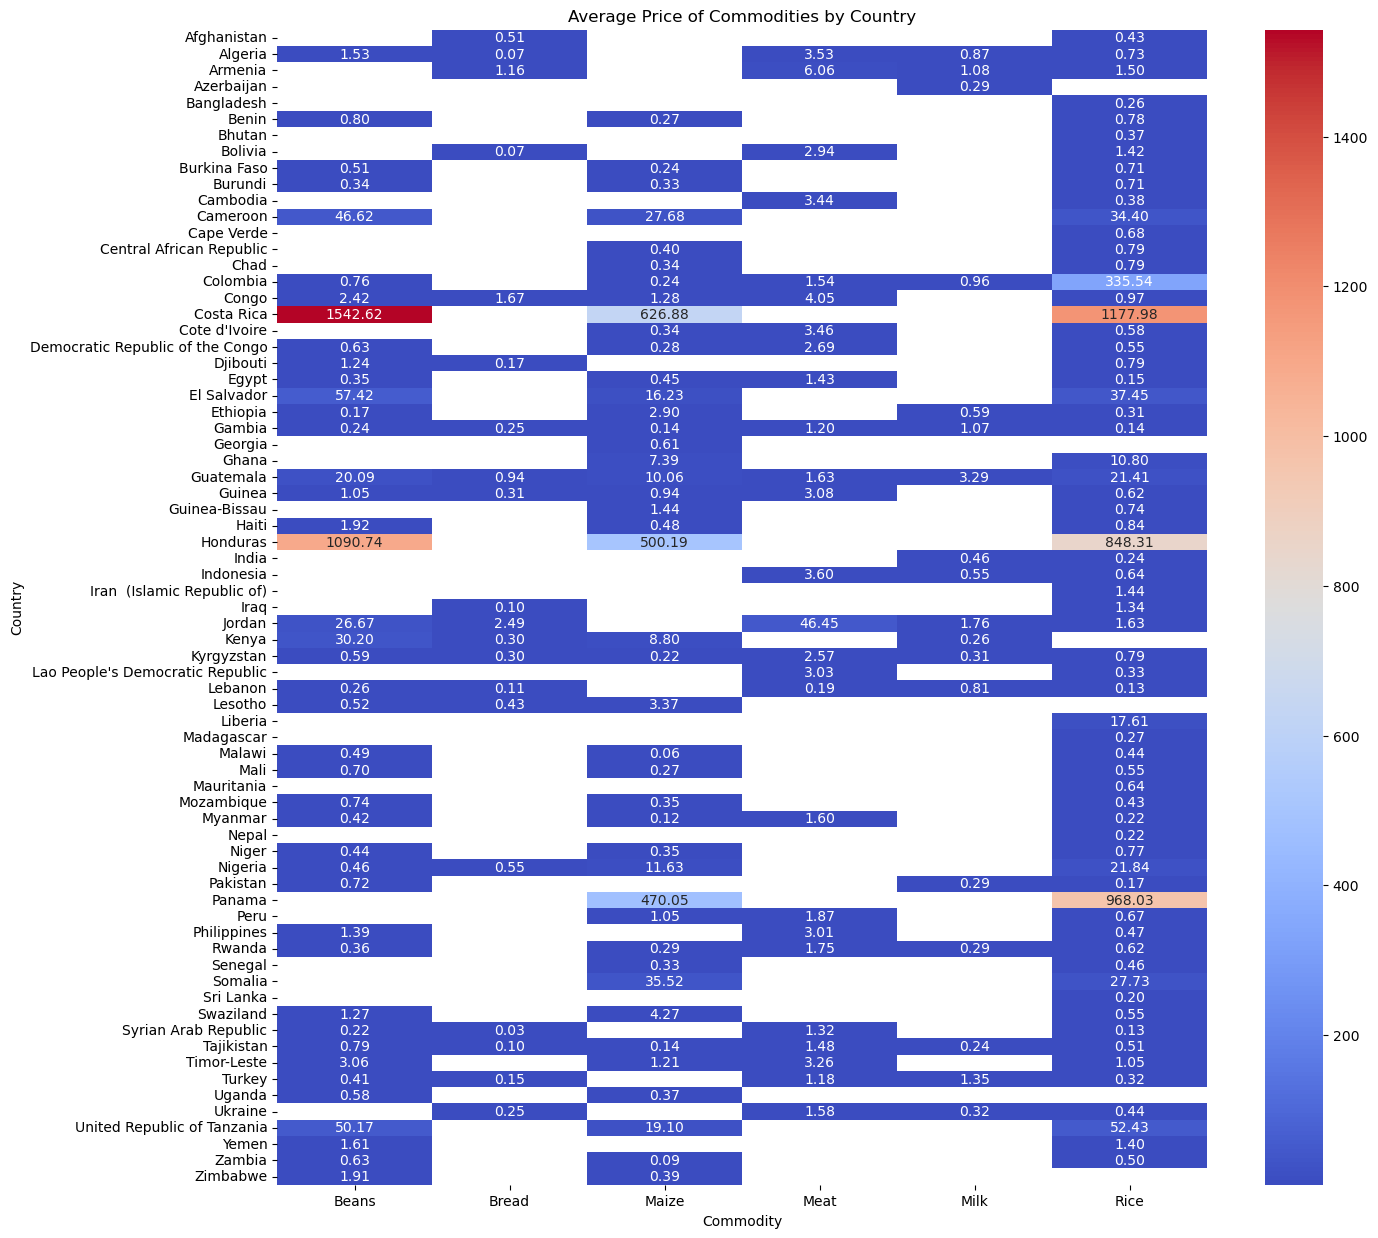

In [34]:
# Set the plot size
plt.figure(figsize=(15, 15))

# Create the heatmap
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt='.2f')

# Set the title and labels
plt.title('Average Price of Commodities by Country')
plt.xlabel('Commodity')
plt.ylabel('Country')

# Show the plot
plt.show()

Based on the heatmap, it is evident that there is a significant variation in food prices across developing countries. However, Costa Rica, Honduras, and Panama stand out as countries with notably higher food prices compared to the rest. Similarly, the price of rice in Colombia is relatively higher than other developing countries. These insights suggest that food prices are influenced by various factors such as economic policies, trade barriers, and natural disasters.

To address the high food prices in Costa Rica, Honduras, and Panama, policymakers should prioritize measures aimed at promoting food security and reducing the cost of production. This can be achieved by implementing policies that enhance agricultural productivity, such as providing farmers with access to credit, improving infrastructure, and investing in research and development.

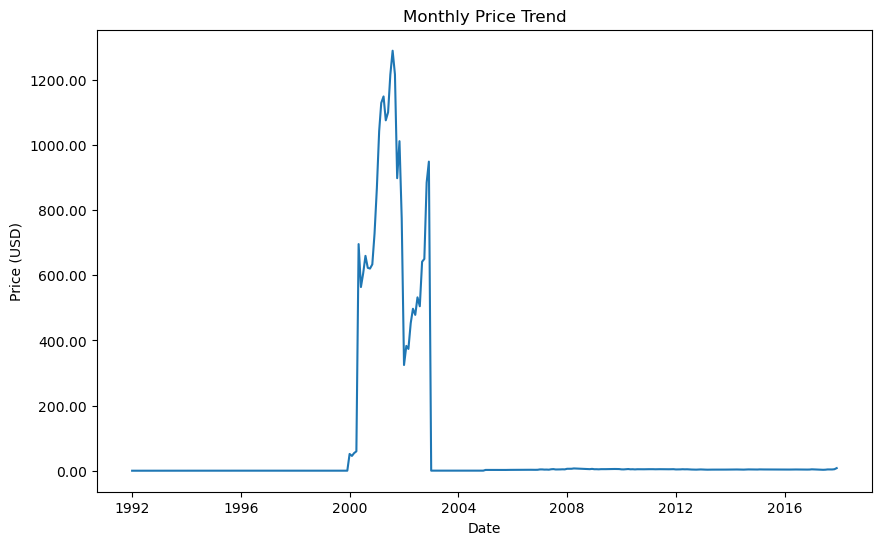

In [35]:
# Group the data by date and calculate the mean price for each month
monthly_prices = merged_df.groupby('Date')['Price_USD'].mean()

# Create a line plot of the monthly prices
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(monthly_prices.index, monthly_prices.values)
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.set_title('Monthly Price Trend')
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
plt.show()

In [36]:
Nigeria_df = merged_df[(merged_df["Country"] == "Nigeria")]
Nigeria_df
Nigeria_df.to_csv("Nigeria_df.csv", index=False)

In [37]:
Nigeria_df

,Country,Region,Market,Commodity,Currency,Market_type,Quantity,Month,Year,Price,Source,USD Equivalent,Price_USD,Date,Commodity_f
458707,Nigeria,Sokoto,Illela (CBM),Maize,NGN,Wholesale,KG,1,2002,153.3485,SIMA - Niger,459.83,0.33,2002-04-01,Maize
458708,Nigeria,Sokoto,Illela (CBM),Maize,NGN,Wholesale,KG,3,2002,171.2454,SIMA - Niger,459.83,0.37,2002-01-01,Maize
458709,Nigeria,Sokoto,Illela (CBM),Maize,NGN,Wholesale,KG,4,2002,188.3671,SIMA - Niger,459.83,0.41,2002-02-01,Maize
458710,Nigeria,Sokoto,Illela (CBM),Maize,NGN,Wholesale,KG,5,2002,189.0390,SIMA - Niger,459.83,0.41,2002-03-01,Maize
458711,Nigeria,Sokoto,Illela (CBM),Maize,NGN,Wholesale,KG,6,2002,187.8219,SIMA - Niger,459.83,0.41,2002-04-01,Maize
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469108,Nigeria,Kaduna,Saminaka,Gari (white),NGN,Wholesale,100 KG,1,2017,19475.0000,"FEWS NET, Nigeria",459.83,42.35,2017-08-01,None
469109,Nigeria,Kaduna,Saminaka,Gari (white),NGN,Wholesale,100 KG,2,2017,20700.0000,"FEWS NET, Nigeria",459.83,45.02,2017-09-01,None
469110,Nigeria,Kaduna,Saminaka,Gari (white),NGN,Wholesale,100 KG,3,2017,22380.0000,FEWSNET,459.83,48.67,2017-11-01,None
469111,Nigeria,Kaduna,Saminaka,Gari (white),NGN,Wholesale,100 KG,4,2017,21595.0000,FEWS NET,459.83,46.96,2017-12-01,None


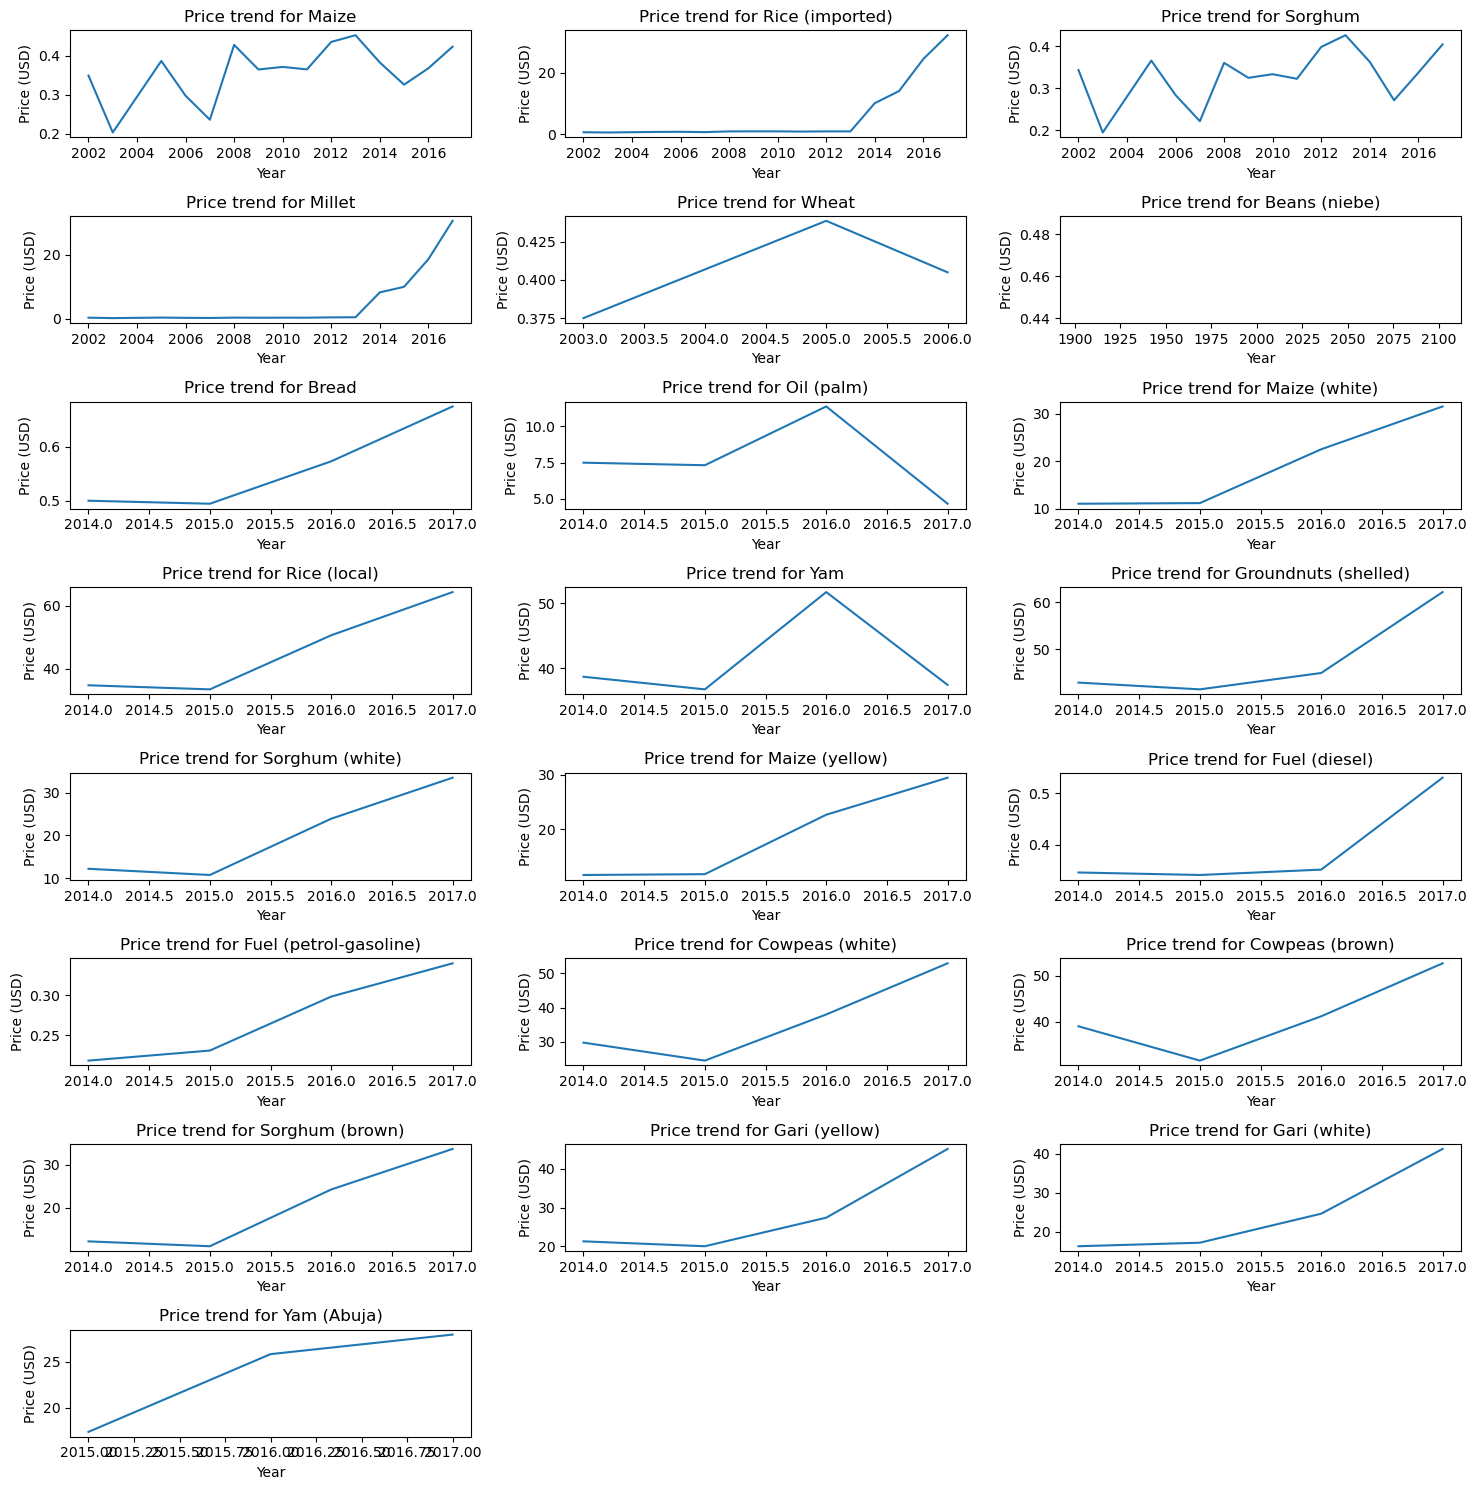

In [38]:
commodities = Nigeria_df["Commodity"].unique()

# group data by year and commodity
grouped_data_ng = Nigeria_df.groupby(['Year', 'Commodity'])['Price_USD'].mean().reset_index()

# define number of rows and columns in plot grid
num_rows = len(commodities) // 3 + (len(commodities) % 3 > 0)
num_cols = 3

# create plot grid with specified number of rows and columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# loop through commodities and plot each one in its own subplot
for i, commodity in enumerate(commodities):
    # filter data for the current commodity
    commodity_data = grouped_data_ng[grouped_data_ng['Commodity'] == commodity]
    
    # calculate the row and column index for the current subplot
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    # plot the data in the current subplot
    axs[row_idx, col_idx].plot(commodity_data['Year'], commodity_data['Price_USD'])
    axs[row_idx, col_idx].set_title(f'Price trend for {commodity}')
    axs[row_idx, col_idx].set_xlabel('Year')
    axs[row_idx, col_idx].set_ylabel('Price (USD)')
    
# remove any unused subplots
for i in range(len(commodities), num_rows * num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    axs[row_idx, col_idx].axis('off')

# adjust spacing between subplots
fig.tight_layout()

In [39]:
# # Checking price trend of all the commodities across the years
# commodities = (Nigeria_df["Commodity"].unique())
# # group data by year and commodity
# grouped_data_ng = Nigeria_df.groupby(['Year', 'Commodity'])['Price_USD'].mean().reset_index()

# # loop through commodities and create separate plots
# for commodity in commodities:
#     # filter data for the current commodity
#     commodity_data = grouped_data_ng[grouped_data_ng['Commodity'] == commodity]
    
#     # create a new figure and set title
#     plt.figure(figsize=(5, 5))
#     plt.title(f'Price trend for {commodity}')
    
#     # plot the data
#     plt.plot(commodity_data['Year'], commodity_data['Price_USD'])
    
#     # set x and y labels
#     plt.xlabel('Year')
#     plt.ylabel('Price (USD)')

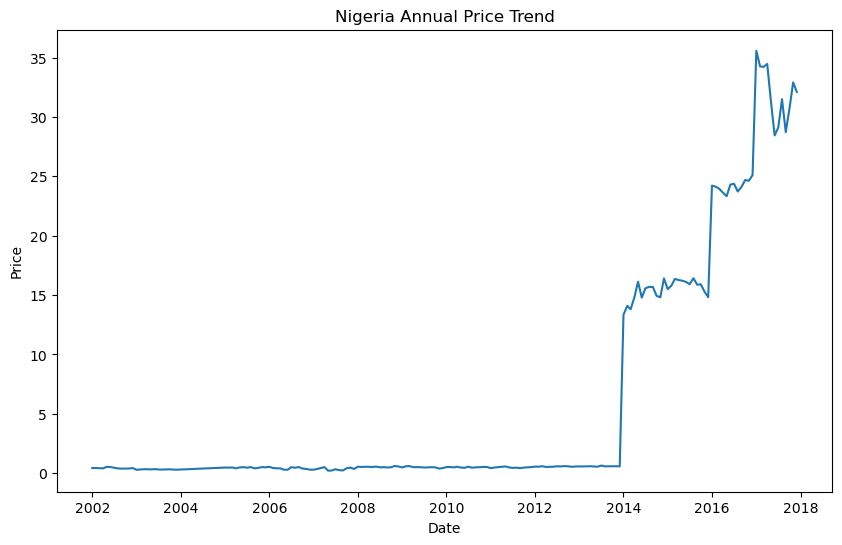

In [40]:
monthly_prices_NG = Nigeria_df.groupby('Date')['Price_USD'].mean()
# Create a line plot of the monthly prices
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(monthly_prices_NG.index, monthly_prices_NG.values)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Nigeria Annual Price Trend')
plt.show()

From the individual commodity charts and the "Nigeria Annual Price Trend" chart, we can see that there is a significant price spike from the year 2014.

### Some of the possible reasons are as follows:

1. **Insecurity**: The country faced a significant increase in insecurity challenges, particularly in the northeastern region, where terrorist attacks by the Boko Haram group and conflicts between herders and farmers resulted in the displacement of many people and disruption of farming activities, leading to a decrease in food supply and an increase in prices.

2. **Currency devaluation**: The Nigerian government devalued the currency in 2014, which led to a significant increase in the cost of imported goods, including food items. This, in turn, led to an increase in the prices of locally produced food items, as the cost of inputs such as fuel, fertilizer, and pesticides also increased. *On 25 November 2014, the Central Bank of Nigeria (CBN) devalued the Naira by nearly 10 per cent and increased its interest rate from 12 to 13 per cent ([Global Trade Alert](http://www.globaltradealert.org/state-act/9707/nigeria-devaluation-of-the-naira-in-november-2014#:~:text=In%20November%202014%2C%20the%20government,devaluation%20of%20its%20national%20currency.&text=On%2025%20November%202014%2C%20the,12%20to%2013%20per%20cent.) 2014, November 25).*

3. **Poor infrastructure**: Nigeria's poor infrastructure, particularly in the transportation and storage of agricultural produce, led to post-harvest losses and food wastage. This reduced the amount of food available in the market, leading to an increase in prices.

4. **Government policies**: The Nigerian government's policies, such as the ban on the importation of certain food items, led to a decrease in the supply of these items and an increase in prices. Also, the government's delay in implementing policies that would enhance agricultural production and reduce food imports also contributed to the increase in food prices.

Overall, the combination of these factors resulted in the skyrocketing of food prices in Nigeria from 2014.

## Build Model

In [41]:
Nigeria_df["Commodity_f"].value_counts()

Maize    1527
Rice     1488
Bread     501
Beans      12
Name: Commodity_f, dtype: int64

In [42]:
# Filter the data for rice and maize
rice_df = Nigeria_df[Nigeria_df['Commodity_f'] == 'Rice']
maize_df = Nigeria_df[Nigeria_df['Commodity_f'] == 'Maize']

In [43]:
rice_df.set_index('Date', inplace=True)
maize_df.set_index('Date', inplace=True)

In [44]:
rice_ts = rice_df['Price_USD']
maize_ts = maize_df['Price_USD']

In [45]:
# Fit the ARIMA models
rice_model = ARIMA(rice_ts, order=(1,1,1)).fit()
maize_model = ARIMA(maize_ts, order=(1,1,1)).fit()

# Forecast the next 5 years
rice_forecast = rice_model.forecast(steps=60)
maize_forecast = maize_model.forecast(steps=60)

rice_forecast_array = rice_forecast.values
maize_forecast_array = maize_forecast.values

# Aggregate the monthly forecasts into yearly forecasts
rice_yearly_forecast = rice_forecast_array.reshape(-1, 12).mean(axis=1)
maize_yearly_forecast = maize_forecast_array.reshape(-1, 12).mean(axis=1)

# Print the forecasted prices
print('Rice price forecast (per year):')
for i, price in enumerate(rice_yearly_forecast):
    print(f"Year {i+1}: {price:.2f}")
print('\n')

print('Maize price forecast (per year):')
for i, price in enumerate(maize_yearly_forecast):
    print(f"Year {i+1}: {price:.2f}")

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels

Rice price forecast (per year):
Year 1: 64.04
Year 2: 64.04
Year 3: 64.04
Year 4: 64.04
Year 5: 64.04


Maize price forecast (per year):
Year 1: 23.70
Year 2: 19.46
Year 3: 18.71
Year 4: 18.58
Year 5: 18.55


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


In [46]:
# Convert the Series to NumPy arrays
rice_forecast_array = rice_forecast.values
maize_forecast_array = maize_forecast.values

# Aggregate the monthly forecasts into yearly forecasts
rice_yearly_forecast = rice_forecast_array.reshape(-1, 12).mean(axis=1)
maize_yearly_forecast = maize_forecast_array.reshape(-1, 12).mean(axis=1)

# Create DataFrames for the yearly forecasts
rice_forecast_df = pd.DataFrame(rice_yearly_forecast, columns=['Price'])
rice_forecast_df['Year'] = range(1, 6)
rice_forecast_df.set_index('Year', inplace=True)

maize_forecast_df = pd.DataFrame(maize_yearly_forecast, columns=['Price'])
maize_forecast_df['Year'] = range(1, 6)
maize_forecast_df.set_index('Year', inplace=True)

# Save the DataFrames as CSV files
rice_forecast_df.to_csv('rice_forecast.csv')
maize_forecast_df.to_csv('maize_forecast.csv')

#### *Note that these forecasted prices are based on the assumption that the underlying time series follows the same pattern as observed in the historical data. However, actual prices may differ due to various factors such as changes in supply and demand, weather conditions, government policies, and other unforeseen events.*